# 6.5 Lab: Linear Models and Regularization

Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 6.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 8.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for l0bnb: filename=l0bnb-1.0.0-py3-none-any.whl size=22298 sha256=4ca850fabef1d783532422329565e211b0b05925c497936b958d56d246a47911
  Stored in directory: /home/adarsh/.cache/pip/wheels/56/b6/7a/2a78772d92aa67f0d038759a09c7e950b5a708d5ecd5c0e38d
Successfully built l0bnb


## 6.5.1 Subset Selection Methods

In [4]:
Hitters = load_data("Hitters")
np.isnan(Hitters["Salary"]).sum()

59

In [5]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [6]:
def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat) ** 2)
    return -(RSS + 2 * p * sigma2) / n

In [7]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)
Y = np.array(Hitters["Salary"])
X = design.transform(Hitters)
sigma2 = OLS(Y, X).fit().scale

In [8]:
negCp = partial(nCp, sigma2)

In [9]:
strategy = Stepwise.first_peak(design,
                               direction="forward",
                               max_terms=len(design.terms))

In [10]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [11]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=negCp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### Choosing among Methods Using the Validation Set approach and cross validation

In [12]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction="forward")
full_path = sklearn_selection_path(OLS, strategy)

In [13]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

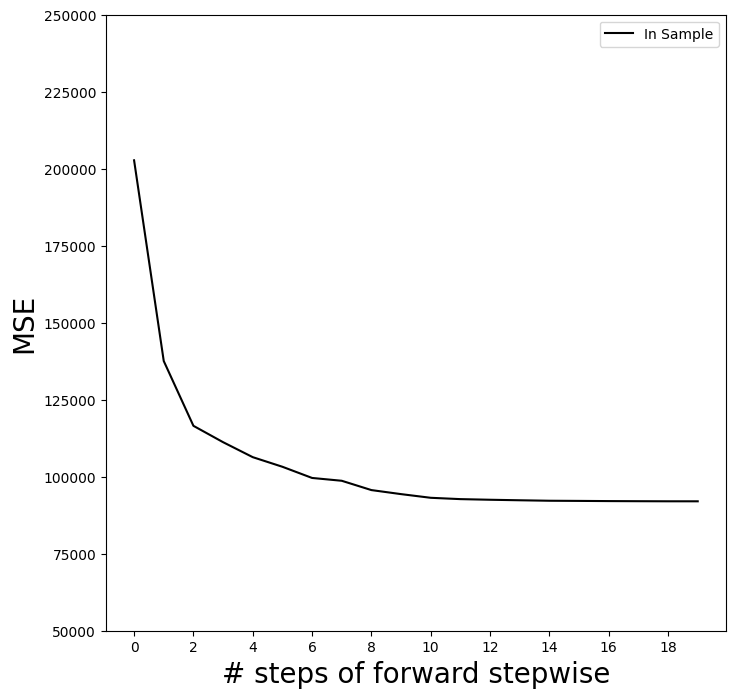

In [14]:
mse_fig, ax = subplots(figsize=(8, 8))
insample_mse = ((Yhat_in - Y[:, None]) ** 2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        "k",
        label="In Sample")
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("# steps of forward stepwise", fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

In [15]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

In [16]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None]) ** 2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

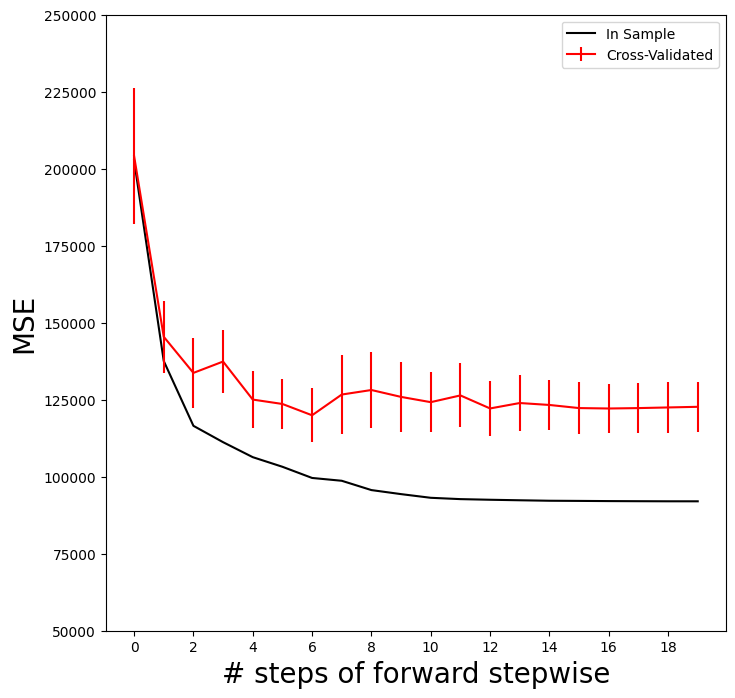

In [17]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label="Cross-Validated",
            c="r")
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [18]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None]) ** 2
    validation_mse = errors.mean(0)

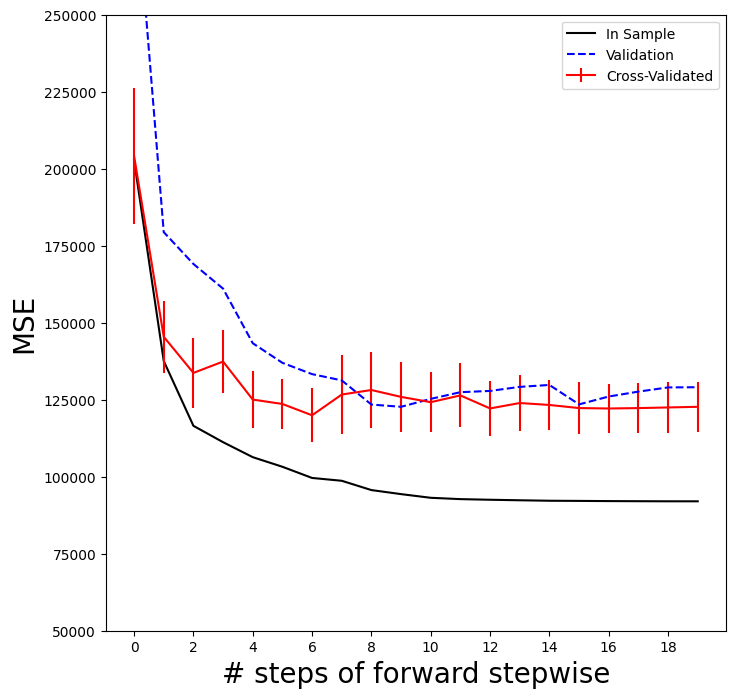

In [19]:
ax.plot(np.arange(n_steps),
        validation_mse,
        "b--",
        label="Validation")
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

### Best Subset Selection

In [21]:
D = design.fit_transform(Hitters)
D = D.drop("intercept", axis=1)
X = np.asarray(D)

In [22]:
path = fit_path(X,
                Y,
                max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [23]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

## 6.5.2 Ridge and the Lasso

### Ridge Regression

In [24]:
Xs = X - X.mean(0)[None, :]
X_scale = X.std(0)
Xs = Xs / X_scale[None, :]
lambdas = 10 ** np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0,
                                 alphas=lambdas)[1]
soln_array.shape

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614:

(19, 100)

In [25]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = "negative log(lambda)"
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


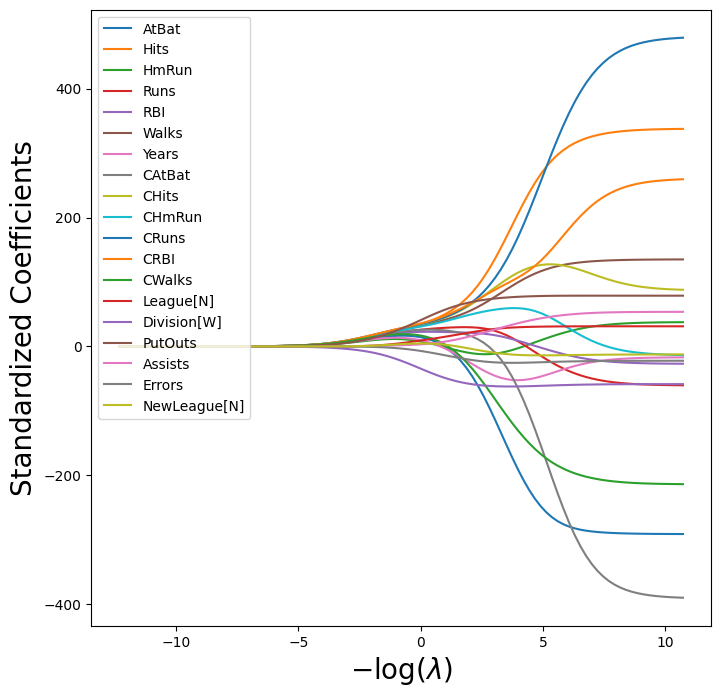

In [26]:
path_fig, ax = subplots(figsize=(8, 8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Standardized Coefficients", fontsize=20)
ax.legend(loc="upper left")


In [27]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [28]:
np.linalg.norm(beta_hat)

24.17061720144378

In [29]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725912)

In [30]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[("scaler", scaler), ("ridge", ridge)])
pipe.fit(X, Y)

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [31]:
np.linalg.norm(ridge.coef_)

160.42371017725904

### Estimating Test Error of Ridge Regression

In [35]:
validation = skm.ShuffleSplit(n_splits=1,
                               test_size=0.5,
                               random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge, X, Y, scoring="neg_mean_squared_error", cv=validation)
-results["test_score"]

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

In [36]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge, X, Y, scoring="neg_mean_squared_error", cv=validation)
-results["test_score"]

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

In [39]:
param_grid = {"ridge__alpha": lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring="neg_mean_squared_error")
grid.fit(X, Y)
grid.best_params_["ridge__alpha"]
grid.best_estimator_

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [40]:
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring="neg_mean_squared_error")
grid.fit(X, Y)
grid.best_params_["ridge__alpha"]
grid.best_estimator_

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Text(0, 0.5, 'Cross-Validated MSE')

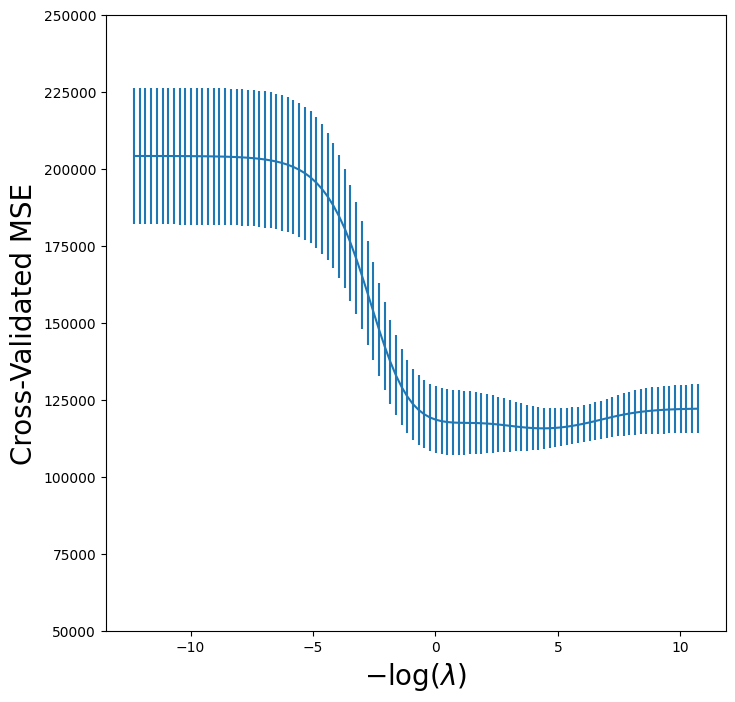

In [41]:
ridge_fig, ax = subplots(figsize=(8, 8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_["mean_test_score"],
            yerr=grid.cv_results_["std_test_score"] / np.sqrt(K))
ax.set_ylim([50000, 250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-Validated MSE", fontsize=20)

In [42]:
grid_r2 = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold)
grid_r2.fit(X, Y)

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Text(0, 0.5, 'Cross-Validated $R^2$')

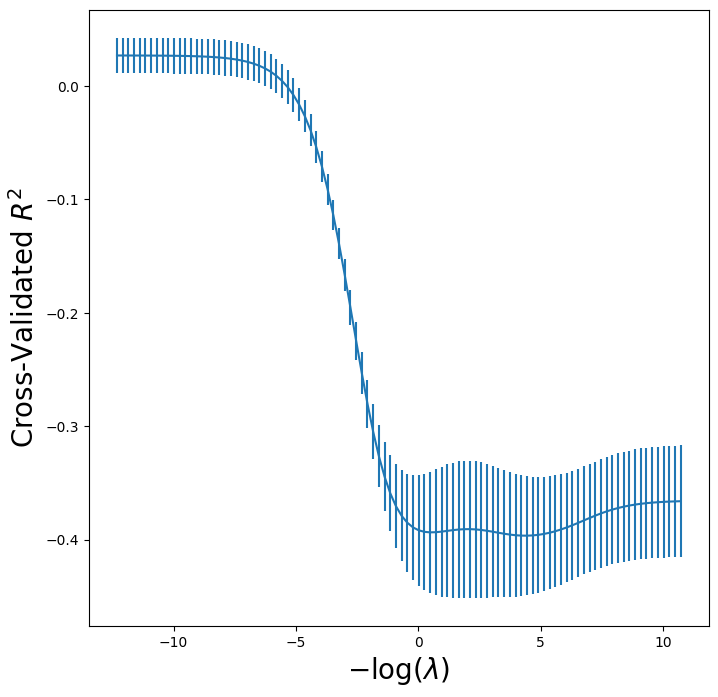

In [47]:
r2_fig, ax = subplots(figsize=(8, 8))
ax.errorbar(-np.log(lambdas),
            -grid_r2.cv_results_["mean_test_score"],
            yerr=grid_r2.cv_results_["std_test_score"] / np.sqrt(K))
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-Validated $R^2$", fontsize=20)

### Fast Cross-Validation for Solution Paths

In [48]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[("scaler", scaler), ("ridge", ridgeCV)])
pipeCV.fit(X, Y)

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795326.355502333, tolerance: 3759.109166869193
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:61

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross-Validated MSE')

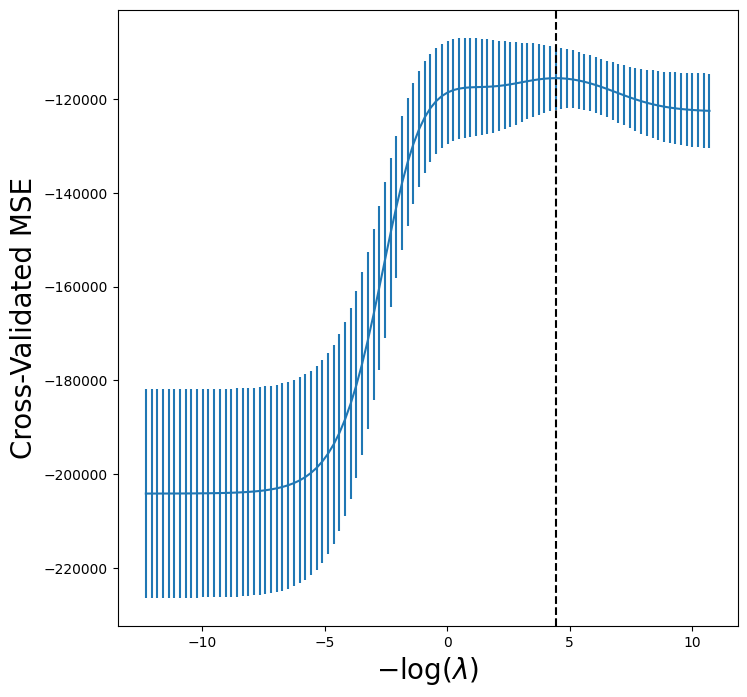

In [51]:
tuned_ridge = pipeCV.named_steps["ridge"]
ridgeCV_fig, ax = subplots(figsize=(8, 8))
ax.errorbar(-np.log(lambdas),
            -tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c="k", ls="--")
# ax.set_ylim([50000, 250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-Validated MSE", fontsize=20)

In [53]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987729

In [54]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

### Evaluating Test Error of Cross-Validated Ridge

In [55]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[("scaler", scaler), ("ridge", ridgeCV)])

In [56]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring="neg_mean_squared_error")
-results["test_score"]

/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.89304734, tolerance: 3200.6325551004934
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/adarsh/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:61

array([132393.84003227])

### The Lasso

In [60]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[("scaler", scaler), ("lasso", lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps["lasso"]
tuned_lasso.alpha_

3.1472370031649866

In [61]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                     Y,
                                     l1_ratio=1,
                                     n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

Text(0, 0.5, 'Standardized Coefficients')

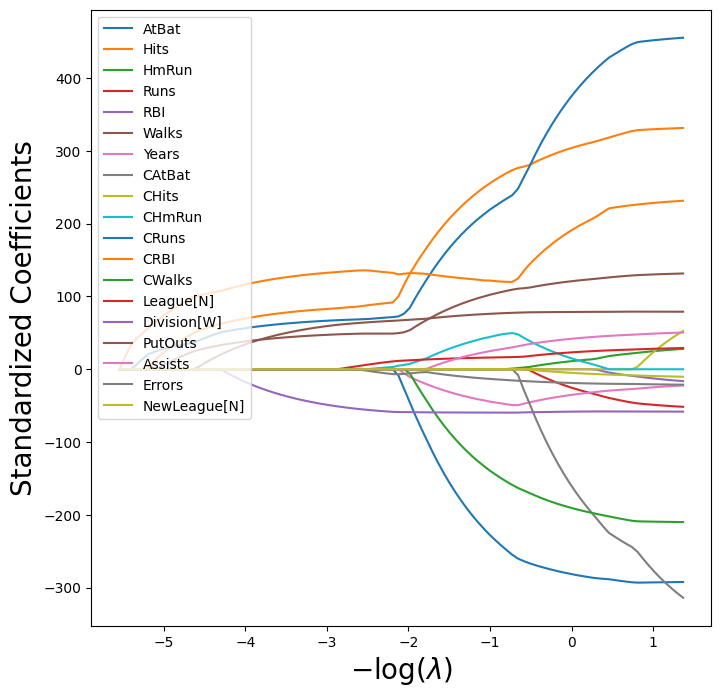

In [62]:
path_fig, ax = subplots(figsize=(8, 8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc="upper left")
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Standardized Coefficients", fontsize=20)

In [63]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253677

Text(0, 0.5, 'Cross-Validated MSE')

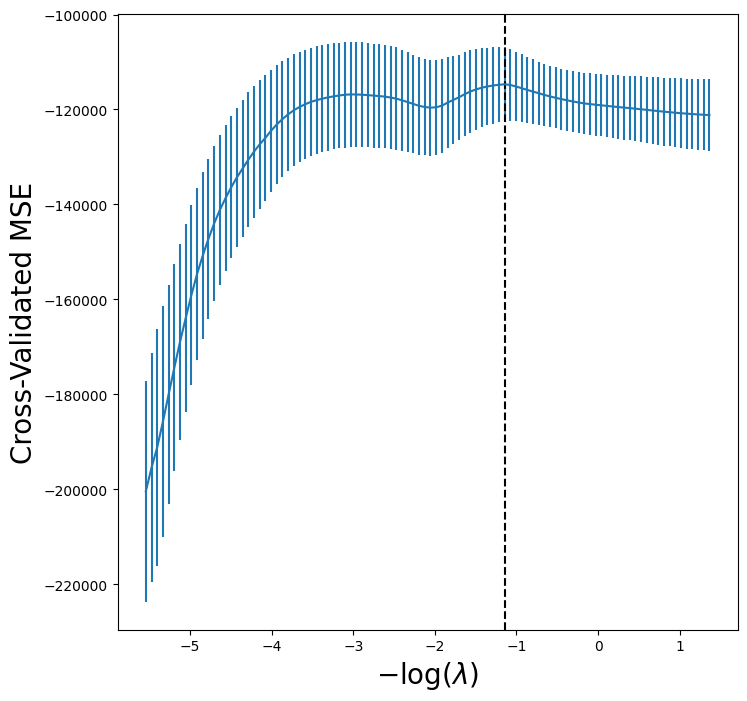

In [64]:
lassoCV_fig, ax = subplots(figsize=(8, 8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            -tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c="k", ls="--")
# ax.set_ylim([50000, 250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-Validated MSE", fontsize=20)

In [65]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

## 6.5.3 PCR and PLS Regression

In [66]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([("pca", pca),
                 ("linreg", linreg)])
pipe.fit(X, Y)
pipe.named_steps["linreg"].coef_

array([0.09846131, 0.4758765 ])

In [67]:
pipe = Pipeline([("scaler", scaler),
                 ("pca", pca),
                 ("linreg", linreg)])
pipe.fit(X, Y)
pipe.named_steps["linreg"].coef_

array([106.36859204, -21.60350456])

In [68]:
param_grid = {"pca__n_components": range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid=param_grid,
                        cv=kfold,
                        scoring="neg_mean_squared_error")
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

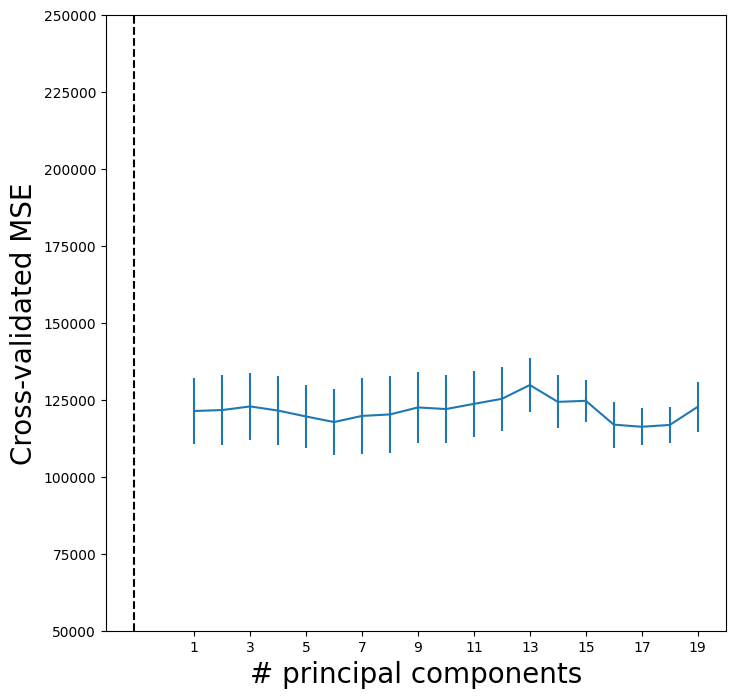

In [71]:
pcr_fig, ax = subplots(figsize=(8, 8))
n_comp = param_grid["pca__n_components"]
ax.errorbar(n_comp,
            -grid.cv_results_["mean_test_score"],
            yerr=grid.cv_results_["std_test_score"] / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c="k", ls="--")
ax.set_ylim([50000, 250000])
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# principal components", fontsize=20)
ax.set_xticks(n_comp[::2])

In [72]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring="neg_mean_squared_error")
-cv_null["test_score"].mean()

204139.30692994667

In [74]:
pipe.named_steps["pca"].explained_variance_ratio_

array([0.3831424 , 0.21841076])

### Partial Least Squares

In [75]:
pls = PLSRegression(n_components=2,
                    scale=True)
pls.fit(X, Y)

PLSRegression()

In [77]:
param_grid = {"n_components": range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid=param_grid,
                        cv=kfold,
                        scoring="neg_mean_squared_error")
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

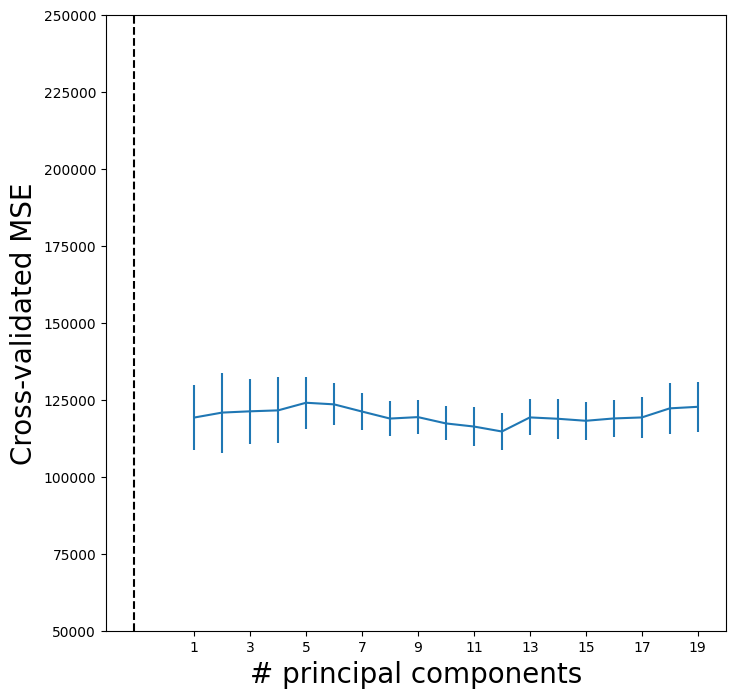

In [78]:
pls_fig, ax = subplots(figsize=(8, 8))
n_comp = param_grid["n_components"]
ax.errorbar(n_comp,
            -grid.cv_results_["mean_test_score"],
            yerr=grid.cv_results_["std_test_score"] / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c="k", ls="--")
ax.set_ylim([50000, 250000])
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# principal components", fontsize=20)
ax.set_xticks(n_comp[::2])